In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("vlag"))

In [2]:
from datetime import datetime, timedelta

# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

US_BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [3]:
import yfinance as yf

# set the end date to today
end_date = datetime.today()
# set the start date to 5 years ago
start_date = end_date - timedelta(days=5 * 365)
print(start_date)

2019-09-09 14:34:27.345927


In [4]:
%load_ext autoreload
%autoreload 2
from interest_rate_fetcher import get_effective_rate

eff_r = get_effective_rate(start_date)
eff_r.tail()

,effective_rate
2024-09-01,0.0533
2024-09-02,0.0533
2024-09-03,0.0533
2024-09-04,0.0533
2024-09-05,0.0533


In [5]:
eff_r.index.dtype

dtype('<M8[ns]')

In [6]:
# list of tickers
tickers = [
    "QQQ",  # Invesco QQQ Trust Nasdaq 100
    "SHV",  # iShares Short Treasury Bond ETF
    "TLT",  # iShares 20+ Year Treasury Bond ETF
    # "DIS",  # Disney
    "PFE",  # Phizer
    "T",  # AT&T
    "GSK",  #
    "LVS",  # Las Vegas Sand Corp
    "OXY",  # Occidental Petroleum Corporation
    # 'MMM',  # 3M
    "KO",  # Coca-Cola
    "KHC",  # Kraft Heinz
    "ABT",  # Abbott Labs
]

# tickers = [
#     "QQQ",
#     "VHT",  # Vanguard Health Care Index Fund ETF Shares
#     "XLE",  # The Energy Select Sector SPDR Fund
#     "VCR",  # Vanguard Consumer Discretionary ETF
#     "VPU",  # Vanguard Utilities ETF

# ]
market = ["^GSPC"]

close_df = pd.DataFrame()
close_df = yf.download(tickers, start=start_date, end=end_date)["Close"]
market_df = yf.download(market, start=start_date, end=end_date)["Close"]
close_df.index = close_df.index.tz_localize(None)
close_df.tail()

[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  1 of 1 completed


Ticker,ABT,GSK,KHC,KO,LVS,OXY,PFE,QQQ,SHV,T,TLT
Date,,,,,,,,,,,
2024-08-30,113.269997,43.910000,35.430000,72.470001,38.990002,56.980000,29.010000,476.269989,110.599998,19.900000,96.489998
2024-09-03,114.660004,43.439999,35.590000,73.010002,38.680000,55.400002,28.299999,461.809998,110.160004,20.430000,97.750000
2024-09-04,114.400002,44.259998,36.070000,72.559998,39.860001,54.630001,28.389999,460.609985,110.190002,20.570000,99.010002
2024-09-05,113.099998,43.130001,36.130001,71.169998,39.980000,53.740002,28.510000,461.040009,110.209999,20.650000,99.570000
2024-09-06,113.860001,43.669998,35.840000,71.139999,39.700001,52.029999,28.559999,448.690002,110.260002,20.969999,99.559998


In [7]:
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Paired"))

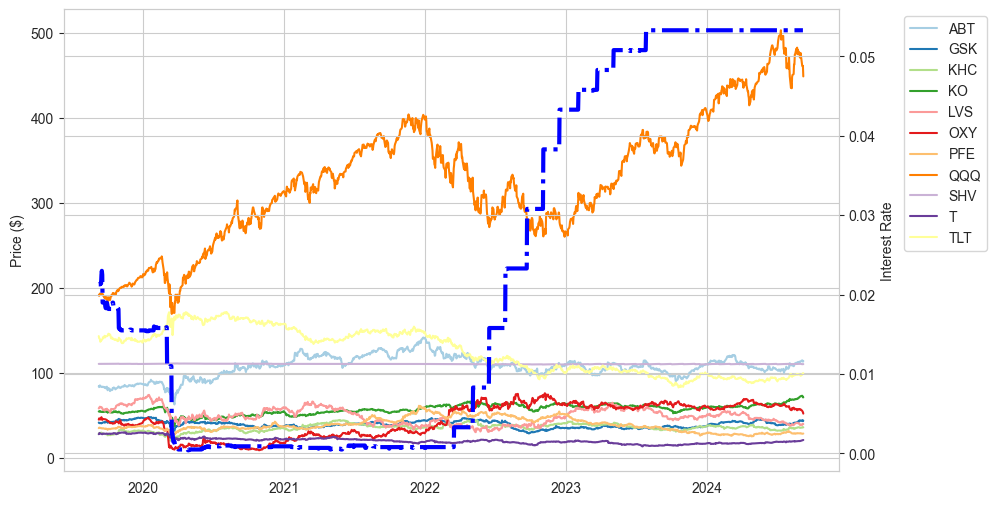

In [8]:
fig_prices, ax = plt.subplots(figsize=(10, 6))
ax_rate = ax.twinx()


for _c in close_df.columns:

    ax.plot(close_df[_c], label=_c)


ax_rate.plot(eff_r, color="b", linestyle="dashdot", linewidth=3)


ax.set_ylabel("Price ($)")
ax_rate.set_ylabel("Interest Rate")


ax.legend(loc="best", bbox_to_anchor=(1.2, 1))


# fig_prices

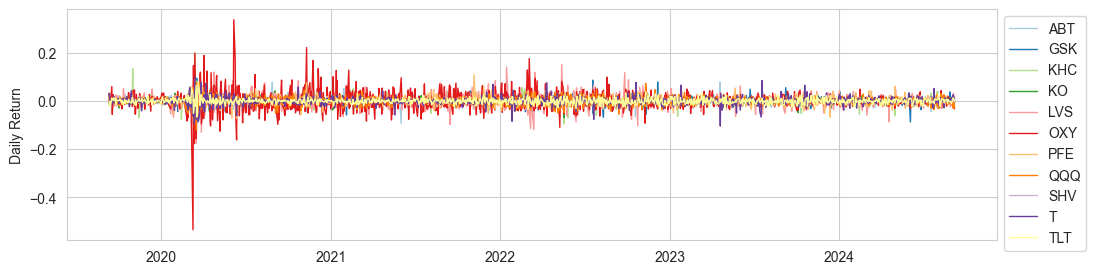

In [9]:
fig_daily_return, ax = plt.subplots(figsize=(12, 3))
for _c in close_df.columns:
    ax.plot(close_df[_c].pct_change(), label=_c, linewidth=1)
# ax.set_ylim([-0.6, 0.4])
ax.set_ylabel("Daily Return")
ax.legend(loc="best", bbox_to_anchor=(1, 1))

In [10]:
# annulized daily returns
close_df.pct_change().mean() * 252

Ticker
ABT    0.094566
GSK    0.038340
KHC    0.088682
KO     0.075059
LVS    0.023323
OXY    0.242247
PFE   -0.003546
QQQ    0.203596
SHV   -0.000415
T     -0.020877
TLT   -0.056804
dtype: float64

In [11]:
daily_returns = close_df.pct_change()

# annulized volatility
daily_returns.std() * np.sqrt(252)

Ticker
ABT    0.261349
GSK    0.236401
KHC    0.282698
KO     0.207766
LVS    0.446353
OXY    0.631929
PFE    0.272152
QQQ    0.254595
SHV    0.008785
T      0.266450
TLT    0.179342
dtype: float64

In [12]:
# individual Sharpe ratios
(close_df.pct_change().mean() * 252 - 0.03) / (daily_returns.std() * np.sqrt(252))

Ticker
ABT    0.247050
GSK    0.035280
KHC    0.207578
KO     0.216872
LVS   -0.014959
OXY    0.335871
PFE   -0.123262
QQQ    0.681853
SHV   -3.462036
T     -0.190946
TLT   -0.484017
dtype: float64

In [13]:
weights = np.array(len(tickers) * [1 / len(tickers)])
port_vol = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov(), weights))) * np.sqrt(
    252
)
port_return = np.mean(close_df.pct_change().mean() * 252)

# portfolio volatility (equal weighted)
print("Portfolio volatility (equal weighted): {:.4%}".format(port_vol))

# portfolio return (equal weighted)
print("Portfolio return (equal weighted): {:.4%}".format(port_return))

print("Portfolio Sharpe ratio: {:4%}".format((port_return - 0.03) / port_vol))

Portfolio volatility (equal weighted): 16.3648%
Portfolio return (equal weighted): 6.2197%
Portfolio Sharpe ratio: 19.674688%


### Efficient Frontier

In [14]:
from scipy.optimize import minimize


class Portfolio:
    trading_days = 252

    def __init__(
        self,
        products_names: list,
        daily_prices: pd.DataFrame,
        risk_free: pd.DataFrame,
        weights: np.array = None,
    ) -> None:
        self.products = products_names
        self.daily_prices = daily_prices
        self.daily_prices.index = self.daily_prices.index.tz_localize(None)
        self.risk_free = risk_free
        # equally weighted by default
        if weights is None:
            self.weights = np.array(len(self.products) * [1 / len(self.products)])
        else:
            self.weights = weights

    def daily_returns(self):
        return (
            self.daily_prices.pct_change()
            .dropna(how="any")
            .merge(
                self.risk_free.divide(365),
                how="left",
                left_index=True,
                right_index=True,
            )
            .ffill()
        )

    def daily_excess_returns(self):
        daily_returns = self.daily_returns()
        for _c in daily_returns.columns:
            daily_returns[_c] = daily_returns[_c].sub(daily_returns["effective_rate"])
        return daily_returns.drop(["effective_rate"], axis=1)

    # def port_ret(self):
    #     mean = self.daily_returns().mean()
    #     return np.sum(mean * self.weights) * self.trading_days

    def port_excess_ret(self):
        mean = self.daily_excess_returns().mean()
        return np.sum(mean * self.weights) * self.trading_days

    def port_vol(self):
        cov = self.daily_excess_returns().cov()
        return np.sqrt(np.dot(self.weights.T, np.dot(cov, self.weights))) * np.sqrt(
            self.trading_days
        )

    def sharpe_ratio(self):
        return self.port_excess_ret() / self.port_vol()

    def manual_input_weights(self):
        print("Fill in the current value of each asset (in $): ")
        values = []
        for p in self.products:
            v = input(p + ": ")
            if len(v) == 0:
                values.append(0)
            else:
                values.append(float(v))
        self.weights = np.array(values) / sum(values)
        self.info(sum(values))

    def info(self, total_value=None):
        print("Portfolio composition: ")
        if total_value is None:
            print(
                "{:^11s} {:>8s}  ".format(
                    "Products",
                    "Weights",
                )
            )
            for i in range(len(self.products)):
                print(
                    "{:^11s} {:>8.2%} ".format(
                        self.products[i],
                        self.weights.tolist()[i],
                    )
                )
        else:
            values = self.weights * total_value
            print("{:^11s} {:>8s}  {:>10s}".format("Products", "Weights", "Amounts"))
            for i in range(len(self.products)):
                print(
                    "{:^11s} {:>8.2%}  ${:>9,.2f}".format(
                        self.products[i], self.weights.tolist()[i], values[i]
                    )
                )
        print(
            "{:>20s}: {:>8.2%}".format("Expected excess return", self.port_excess_ret())
        )
        print("{:>20s}: {:>8.2%}".format("Standard deviation", self.port_vol()))
        print("{:>20s}: {:>8.2%}".format("Sharpe Ratio", self.sharpe_ratio()))


port = Portfolio(tickers, close_df, eff_r)
print(port.daily_excess_returns().isnull().values.any())
port.daily_excess_returns()

False


,ABT,GSK,KHC,KO,LVS,OXY,PFE,QQQ,SHV,T,TLT
Date,,,,,,,,,,,
2019-09-10,-0.012051,-0.014282,0.031281,-0.002259,0.015954,0.032408,0.014875,-0.002935,-0.000239,0.021415,-0.017586
2019-09-11,0.015685,-0.001770,0.010991,0.006743,0.004856,-0.003074,0.000744,0.009331,0.000123,0.030809,-0.001835
2019-09-12,0.008105,0.005086,-0.008597,0.006149,0.014276,-0.019285,-0.003533,0.004099,0.000032,-0.009351,-0.006609
2019-09-13,-0.011090,-0.003471,0.007520,-0.015482,-0.013525,-0.006887,-0.009984,-0.003630,-0.000059,-0.012305,-0.021418
2019-09-16,-0.010860,-0.007154,0.012588,-0.005591,0.004994,0.060040,-0.002229,-0.004528,-0.000062,-0.015889,0.012682
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,0.004377,0.003741,0.004675,0.005683,0.008912,-0.004166,0.009951,0.011773,0.000216,0.006939,-0.010809
2024-09-03,0.012126,-0.010850,0.004370,0.007305,-0.008097,-0.027875,-0.024620,-0.030507,-0.004124,0.026487,0.012912
2024-09-04,-0.002414,0.018731,0.013341,-0.006310,0.030361,-0.014045,0.003034,-0.002745,0.000126,0.006707,0.012744


In [15]:
port.daily_returns().pivot_table(
    columns=port.daily_excess_returns().index.year, aggfunc="count"
)

Date,2019,2020,2021,2022,2023,2024
ABT,79,253,252,251,250,172
GSK,79,253,252,251,250,172
KHC,79,253,252,251,250,172
KO,79,253,252,251,250,172
LVS,79,253,252,251,250,172
OXY,79,253,252,251,250,172
PFE,79,253,252,251,250,172
QQQ,79,253,252,251,250,172
SHV,79,253,252,251,250,172
T,79,253,252,251,250,172


In [16]:
%timeit port.sharpe_ratio()

11.8 ms ± 438 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
# portfolio volatility (equal weighted)
print("Portfolio volatility (equal weighted): {:.4%}".format(port.port_vol()))
# portfolio return (equal weighted)
print("Portfolio excess return (equal weighted): {:.4%}".format(port.port_excess_ret()))
print("Portfolio Sharpe ratio: {:4%}".format(port.sharpe_ratio()))

Portfolio volatility (equal weighted): 16.3670%
Portfolio excess return (equal weighted): 4.6559%
Portfolio Sharpe ratio: 28.447088%


In [18]:
from pandas import DataFrame
from tqdm import tqdm


class EfficientFrontier(Portfolio):
    def __init__(
        self,
        products_names: list,
        daily_prices: DataFrame,
        risk_free: float,
        weights=None,
        seed: np.int32 = 123,
        n: np.int32 = 10,
    ) -> None:
        super().__init__(products_names, daily_prices, risk_free, weights)
        self.seed = seed
        self.set_seed()
        self.n = n

    def set_seed(self):
        np.random.seed(self.seed)
        print("Set seed as", self.seed)

    def get_random_weights(self):
        r_weights = np.random.uniform(low=0, high=1, size=len(self.products))
        r_weights = r_weights / np.sum(r_weights)
        return r_weights

    def get_risk_return_spectrum(self):
        rr_list = []
        for _i in tqdm(range(self.n)):
            self.weights = self.get_random_weights()
            rr_list.append(
                [self.port_excess_ret(), self.port_vol(), self.sharpe_ratio()]
            )

        return pd.DataFrame(data=rr_list, columns=["return", "std", "sharpe_ratio"])

In [19]:
ef = EfficientFrontier(tickers, close_df, eff_r, n=10**3)
# ef.get_random_weights().shape
rr_df = ef.get_risk_return_spectrum()

Set seed as 123


100%|██████████| 1000/1000 [00:23<00:00, 42.74it/s]


In [20]:
rr_df.shape

(1000, 3)

In [21]:
rr_df.iloc[rr_df["sharpe_ratio"].idxmax()]["return"]

np.float64(0.09457728542635577)

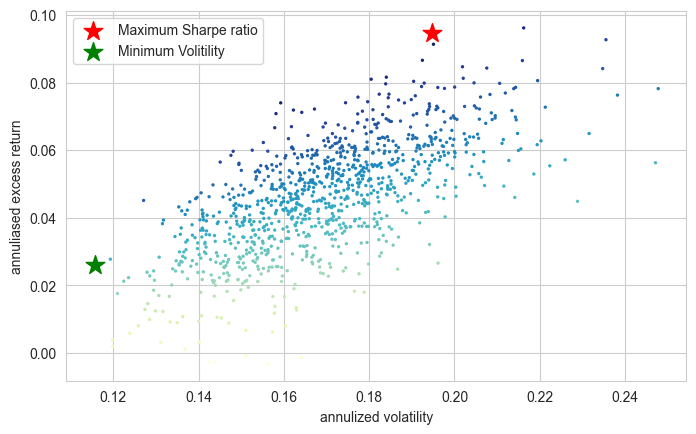

In [22]:
max_sr = rr_df.iloc[rr_df["sharpe_ratio"].idxmax()]
min_sd = rr_df.iloc[rr_df["std"].idxmin()]

fig_efficient_frontier, ax = plt.subplots(figsize=(8, 4.8))
ax.scatter(rr_df["std"], rr_df["return"], c=rr_df["sharpe_ratio"], cmap="YlGnBu", s=2)
ax.scatter(
    max_sr["std"],
    max_sr["return"],
    marker="*",
    color="r",
    s=200,
    label="Maximum Sharpe ratio",
)
ax.scatter(
    min_sd["std"],
    min_sd["return"],
    marker="*",
    color="g",
    s=200,
    label="Minimum Volitility",
)
ax.set_ylabel("annuliased excess return")
ax.set_xlabel("annulized volatility")
ax.legend()

The efficient frontier is not particularly apparent. 

According to this [page](https://quant.stackexchange.com/questions/44210/efficient-frontier-doesnt-look-good), the frontier can also be constructed with the combinations of just two efficient portfolios (e.g. the max sharpe and the min. variance portfolios).

$$
weights = w * \pi_{max\_sr} + (1 - w) * \pi_{min\_var}
$$

### Modern Portfolio Theory (MPT)

In [23]:
from pandas import DataFrame
from scipy.optimize import minimize


class EfficientPortfolio(Portfolio):
    def __init__(
        self,
        products_names: list,
        daily_prices: DataFrame,
        risk_free: float,
        weights=None,
    ) -> None:
        super().__init__(products_names, daily_prices, risk_free, weights)
        self.efficiency: str = "Not optimized"
        # optimized weights are zeros before optimization
        self.optimized_weights = np.zeros(len(self.products))

    def _minus_SR(self, weights):
        self.weights = weights
        return -self.sharpe_ratio()

    def _port_vol_opt(self, weights):
        self.weights = weights
        return self.port_vol()

    def maximiaze_SR(self):
        # constraints, sum of weights = 1
        cons = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
        # bounds on weights: [0, 1]
        bnds = tuple((0, 1) for x in range(len(self.products)))
        # initial guess
        init_w = self.weights
        opts = minimize(
            self._minus_SR, init_w, method="SLSQP", bounds=bnds, constraints=cons
        )
        self.optimized_weights = opts.x
        self.efficiency = "Maximized Sharpe Ratio"

    def minimize_sd(self):
        # constraints, sum of weights = 1
        cons = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
        # bounds on weights: [0, 1]
        bnds = tuple((0, 1) for x in range(len(self.products)))
        # initial guess
        init_w = self.weights
        opts = minimize(
            self._port_vol_opt, init_w, method="SLSQP", bounds=bnds, constraints=cons
        )
        self.optimized_weights = opts.x
        self.efficiency = "Minimized volatility"

In [24]:
eff_port = EfficientPortfolio(
    port.products,
    port.daily_prices,
    port.risk_free,
)
print(eff_port.efficiency)
eff_port.info()

Not optimized
Portfolio composition: 
 Products    Weights  
    QQQ        9.09% 
    SHV        9.09% 
    TLT        9.09% 
    PFE        9.09% 
     T         9.09% 
    GSK        9.09% 
    LVS        9.09% 
    OXY        9.09% 
    KO         9.09% 
    KHC        9.09% 
    ABT        9.09% 
Expected excess return:    4.66%
  Standard deviation:   16.37%
        Sharpe Ratio:   28.45%


In [25]:
eff_port.optimized_weights

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
eff_port.maximiaze_SR()
print(eff_port.efficiency)
eff_port.info()
eff_port.optimized_weights

Maximized Sharpe Ratio
Portfolio composition: 
 Products    Weights  
    QQQ        0.00% 
    SHV        0.00% 
    TLT        0.00% 
    PFE        0.00% 
     T         0.00% 
    GSK        7.85% 
    LVS        0.00% 
    OXY       92.15% 
    KO         0.00% 
    KHC        0.00% 
    ABT        0.00% 
Expected excess return:   19.10%
  Standard deviation:   25.42%
        Sharpe Ratio:   75.13%


array([0.00000000e+00, 2.56626642e-16, 7.67615138e-17, 0.00000000e+00,
       0.00000000e+00, 7.85293876e-02, 1.15912217e-16, 9.21470612e-01,
       0.00000000e+00, 0.00000000e+00, 2.67717955e-17])

In [27]:
eff_port.minimize_sd()
print(eff_port.efficiency)
eff_port.info()

Minimized volatility
Portfolio composition: 
 Products    Weights  
    QQQ        0.02% 
    SHV        0.00% 
    TLT        0.00% 
    PFE        0.05% 
     T         0.05% 
    GSK        0.01% 
    LVS        0.13% 
    OXY        0.00% 
    KO        99.69% 
    KHC        0.05% 
    ABT        0.00% 
Expected excess return:   -1.60%
  Standard deviation:    0.88%
        Sharpe Ratio: -181.36%


In [28]:
eff_port_max_sr = EfficientPortfolio(port.products, port.daily_prices, port.risk_free)
eff_port_max_sr.maximiaze_SR()
eff_port_min_sd = EfficientPortfolio(port.products, port.daily_prices, port.risk_free)
eff_port_min_sd.minimize_sd()

In [29]:
_rr_list = []
for _w in tqdm(np.linspace(-0.2, 1.3, num=10**3)):
    _combined_weights = (
        _w * eff_port_max_sr.weights + (1 - _w) * eff_port_min_sd.weights
    )
    _port = Portfolio(tickers, close_df, eff_r, weights=_combined_weights)
    _rr_list.append(
        [
            _port.port_excess_ret(),
            _port.port_vol(),
            _port.sharpe_ratio(),
        ]
    )
rr_df = pd.DataFrame(data=_rr_list, columns=["return", "std", "sharpe_ratio"])

100%|██████████| 1000/1000 [00:23<00:00, 42.49it/s]


In [30]:
from itertools import compress

_rr_indi_l = []
for _w in np.identity(n=len(tickers)):
    _port = Portfolio(tickers, close_df, eff_r, weights=_w)
    _rr_indi_l.append(
        [
            _port.port_excess_ret(),
            _port.port_vol(),
            _port.sharpe_ratio(),
            list(compress(tickers, _w))[0],
        ]
    )
rr_indi_df = pd.DataFrame(
    data=_rr_indi_l, columns=["return", "std", "sharpe_ratio", "ticker"]
)

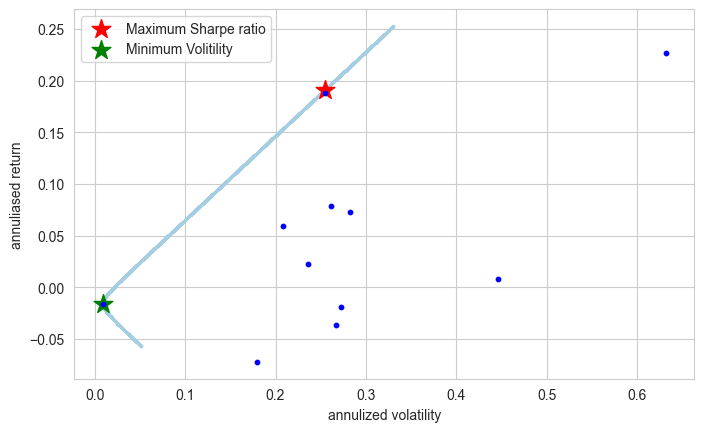

In [31]:
# max_sr = rr_df.iloc[rr_df["sharpe_ratio"].idxmax()]
min_sd = rr_df.iloc[rr_df["std"].idxmin()]

fig_efficient_frontier, ax = plt.subplots(figsize=(8, 4.8))
ax.scatter(rr_df["std"], rr_df["return"], s=2)
ax.scatter(
    eff_port_max_sr.port_vol(),
    eff_port_max_sr.port_excess_ret(),
    marker="*",
    color="r",
    s=200,
    label="Maximum Sharpe ratio",
)
ax.scatter(
    min_sd["std"],
    min_sd["return"],
    marker="*",
    color="g",
    s=200,
    label="Minimum Volitility",
)
ax.scatter(
    rr_indi_df["std"],
    rr_indi_df["return"],
    s=10,
    c="b",
)
ax.set_ylabel("annuliased return")
ax.set_xlabel("annulized volatility")
ax.legend()

In [32]:
# port.manual_input_weights()
# port.info()

### Portfolio of sectors

[*********************100%***********************]  7 of 7 completed


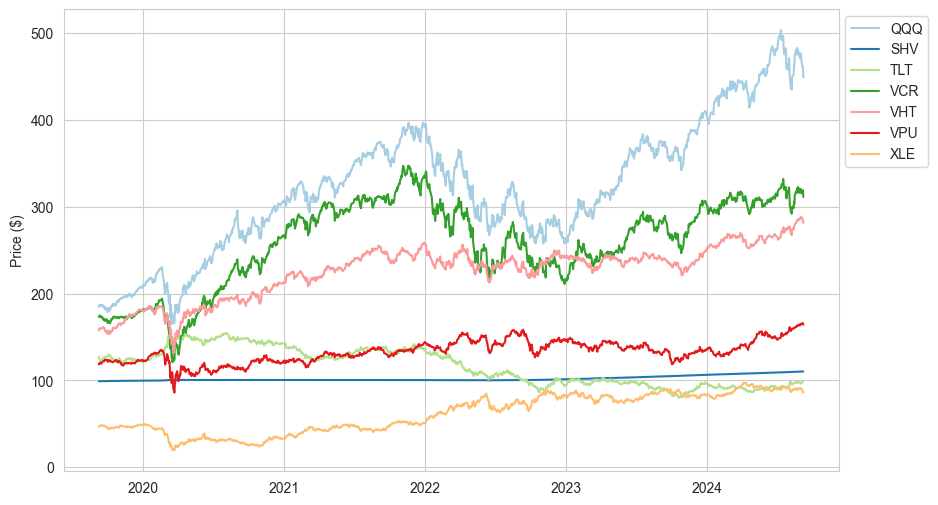

In [33]:
tickers = [
    "QQQ",
    "VHT",  # Vanguard Health Care Index Fund ETF Shares
    "XLE",  # The Energy Select Sector SPDR Fund
    "VCR",  # Vanguard Consumer Discretionary ETF
    "VPU",  # Vanguard Utilities ETF
    "SHV",  # iShares Short Treasury Bond ETF
    "TLT",  # iShares 20+ Year Treasury Bond ETF
]

etf_df = pd.DataFrame()
etf_df = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
etf_df.index = close_df.index.tz_localize(None)

fig_prices, ax = plt.subplots(figsize=(10, 6))
for _c in etf_df.columns:
    ax.plot(etf_df[_c], label=_c)

ax.set_ylabel("Price ($)")
ax.legend(loc="best", bbox_to_anchor=(1, 1))

In [34]:
efficient_etfs = EfficientPortfolio(
    tickers,
    etf_df,
    eff_r,
)


efficient_etfs.maximiaze_SR()


efficient_etfs.info()

Portfolio composition: 
 Products    Weights  
    QQQ        0.29% 
    VHT       99.53% 
    XLE        0.00% 
    VCR        0.00% 
    VPU        0.00% 
    SHV        0.00% 
    TLT        0.18% 
Expected excess return:    0.67%
  Standard deviation:    0.28%
        Sharpe Ratio:  236.40%


[The only trade that matters](https://www.ft.com/content/e05445ef-c6ae-4d42-9d1d-13e120ac3960)

[The market outlook at mid-year: A long road to normal](https://www.jpmorgan.com/insights/global-research/outlook/mid-year-outlook)

*"In U.S. equities, momentum crowding and stock market concentration are now at multi-decade extremes. For this to continue, S&P 500 mega caps will need to keep revising estimates higher and maintain price momentum, which could be challenging."*